# Signal Decay

In this chapter, we use simulated data to show how BOLD signal decays and how we can glean useful information from that decay rate.

In [1]:
import os

import imageio
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sns
from IPython import display
from matplotlib.animation import FuncAnimation
from nilearn import image, plotting
from nilearn.glm import first_level
from repo2data.repo2data import Repo2Data
from scipy import signal

from book_utils import predict_bold_signal

sns.set_style("whitegrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]
})

# Install the data if running locally, or point to cached data if running on neurolibre
DATA_REQ_FILE = os.path.join("../binder/data_requirement.json")

# Download data
repo2data = Repo2Data(DATA_REQ_FILE)
data_path = repo2data.install()
data_path = os.path.abspath(os.path.join(data_path[0], "data"))

out_dir = os.path.join(data_path, "signal-decay")
os.makedirs(out_dir, exist_ok=True)

---- repo2data starting ----
/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/repo2data
Config from file :
../binder/data_requirement.json
Destination:
./../data/multi-echo-data-analysis

Info : ./../data/multi-echo-data-analysis already downloaded


/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Signal decays as echo time increases

In [2]:
func_dir = os.path.join(data_path, "sub-04570/func/")
data_files = [
    os.path.join(func_dir, "sub-04570_task-rest_echo-1_space-scanner_desc-partialPreproc_bold.nii.gz"),
    os.path.join(func_dir, "sub-04570_task-rest_echo-2_space-scanner_desc-partialPreproc_bold.nii.gz"),
    os.path.join(func_dir, "sub-04570_task-rest_echo-3_space-scanner_desc-partialPreproc_bold.nii.gz"),
    os.path.join(func_dir, "sub-04570_task-rest_echo-4_space-scanner_desc-partialPreproc_bold.nii.gz"),
]
echo_times = [12., 28., 44., 60.]

img = image.index_img(data_files[0], 0)
data = img.get_fdata()
vmax = np.max(data)
idx = np.vstack(np.where(data > 1000))

min_x, min_y, min_z = np.min(idx, axis=1)
max_x, max_y, max_z = np.max(idx, axis=1)

imgs = []
for f in data_files:
    img = image.index_img(f, 0)
    data = img.get_fdata()
    data = data[min_x:max_x, min_y:max_y, min_z:max_z]
    img = nib.Nifti1Image(data, img.affine, img.header)
    imgs.append(img)

In [3]:
plt.style.use("dark_background")

fig, axes = plt.subplots(figsize=(26, 4), ncols=len(data_files))
for i_echo, img in enumerate(imgs):
    te = echo_times[i_echo]
    if i_echo == 0:
        data = img.get_fdata()
        vmax = np.max(data)

    plotting.plot_epi(
        img,
        cut_coords=[0],
        display_mode="z",
        annotate=False,
        draw_cross=False,
        axes=axes[i_echo],
        figure=fig,
        vmax=vmax,
        cmap="gray",
    )
    axes[i_echo].set_title(f"TE={te}ms", fontsize=20, pad=0)

fig.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1872x288 with 8 Axes>

## The impact of $T_{2}^{*}$ and $S_{0}$ fluctuations on BOLD signal

In [4]:
plt.style.use("default")

# Simulate data
MULTIECHO_TES = np.array([15, 30, 45, 60, 75, 90])
SINGLEECHO_TE = np.array([30])

# For a nice, smooth curve
FULLCURVE_TES = np.arange(0, 101, 1)

n_echoes = len(FULLCURVE_TES)
pal = sns.color_palette('cubehelix', 8)

### Simulate $T_{2}^{*}$ and $S_{0}$ fluctuations

In [5]:
# Simulate data
# We'll convolve with HRF just for smoothness
hrf = first_level.spm_hrf(1, oversampling=1)

N_VOLS = 21

SCALING_FRACTION = 0.1  # used to scale standard deviation
MEAN_T2S = 35
MEAN_S0 = 16000

# simulate the T2*/S0 time series
# The original time series will be a random time series from a normal distribution,
# convolved with the HRF
ts = np.random.normal(loc=0, scale=1, size=(N_VOLS+20,))
ts = signal.convolve(ts, hrf)[20:N_VOLS+20]
ts *= SCALING_FRACTION / np.std(ts)
ts -= np.mean(ts)

t2s_ts = (ts * MEAN_T2S) + MEAN_T2S
s0_ts = (ts * MEAN_S0) + MEAN_S0

#### Plot BOLD signal decay for a standard single-echo scan

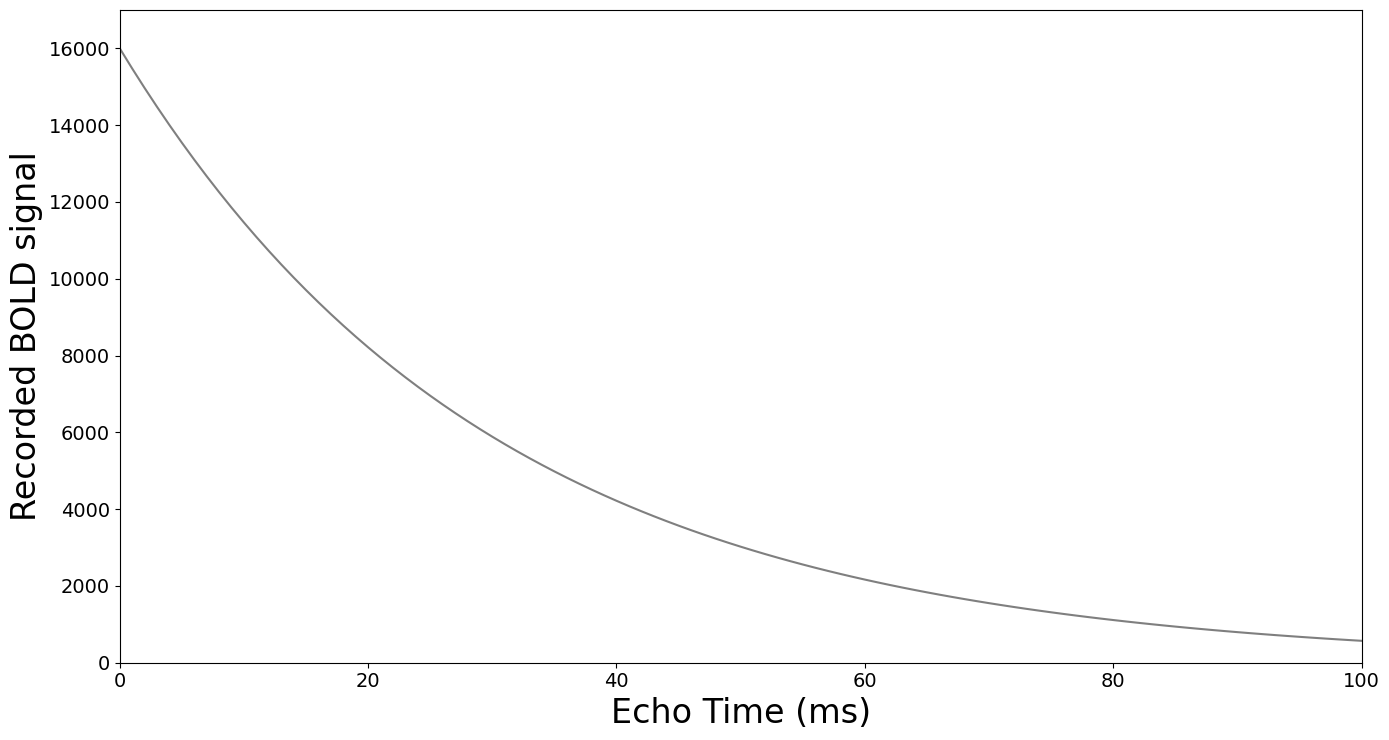

In [6]:
fullcurve_signal = predict_bold_signal(FULLCURVE_TES, [MEAN_S0], [30])

fig, ax = plt.subplots(figsize=(14, 7.5))
ax.plot(
    FULLCURVE_TES,
    fullcurve_signal[:, 0],
    alpha=0.5,
    color="black",
)

ax.set_ylabel("Recorded BOLD signal", fontsize=24)
ax.set_xlabel("Echo Time (ms)", fontsize=24)
ax.set_ylim(0, np.ceil(np.max(fullcurve_signal) / 1000) * 1000)
ax.set_xlim(0, np.max(FULLCURVE_TES))
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()

# save frame
fig.show()

### Plot BOLD signal decay and BOLD contrast

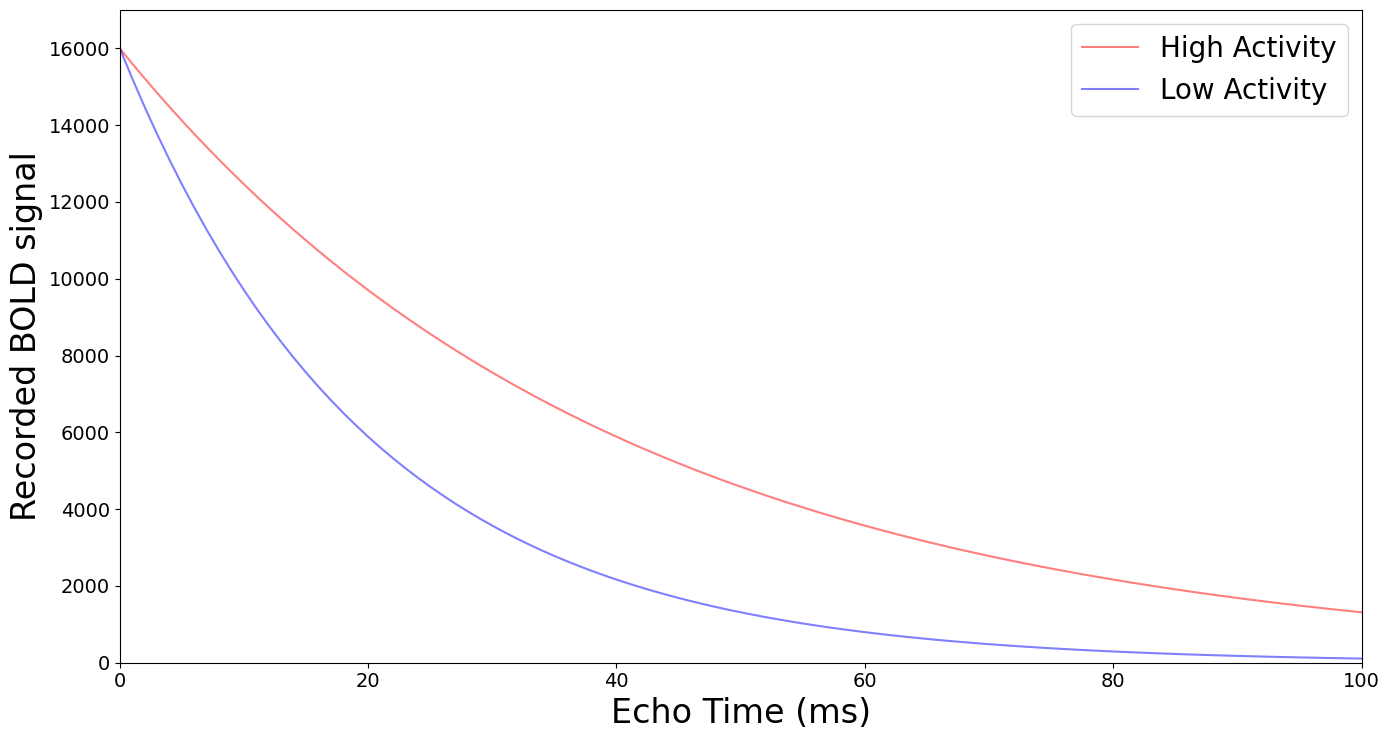

In [7]:
fullcurve_signal_active = predict_bold_signal(FULLCURVE_TES, [MEAN_S0], [40])
fullcurve_signal_inactive = predict_bold_signal(FULLCURVE_TES, [MEAN_S0], [20])

fig, ax = plt.subplots(figsize=(14, 7.5))
ax.plot(
    FULLCURVE_TES,
    fullcurve_signal_active[:, 0],
    alpha=0.5,
    color="red",
    label="High Activity",
)
ax.plot(
    FULLCURVE_TES,
    fullcurve_signal_inactive[:, 0],
    alpha=0.5,
    color="blue",
    label="Low Activity",
)

ax.set_ylabel("Recorded BOLD signal", fontsize=24)
ax.set_xlabel("Echo Time (ms)", fontsize=24)
ax.set_ylim(0, np.ceil(np.max(fullcurve_signal) / 1000) * 1000)
ax.set_xlim(0, np.max(FULLCURVE_TES))
ax.legend(fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()

# save frame
fig.show()

### Plot single-echo data resulting from $S_{0}$ and $T_{2}^{*}$ fluctuations

This shows how fMRI data fluctuates over time.

### Plot single-echo data and the curve resulting from $S_{0}$ and $T_{2}^{*}$ fluctuations

This shows how single-echo data is a sample from a signal decay curve.

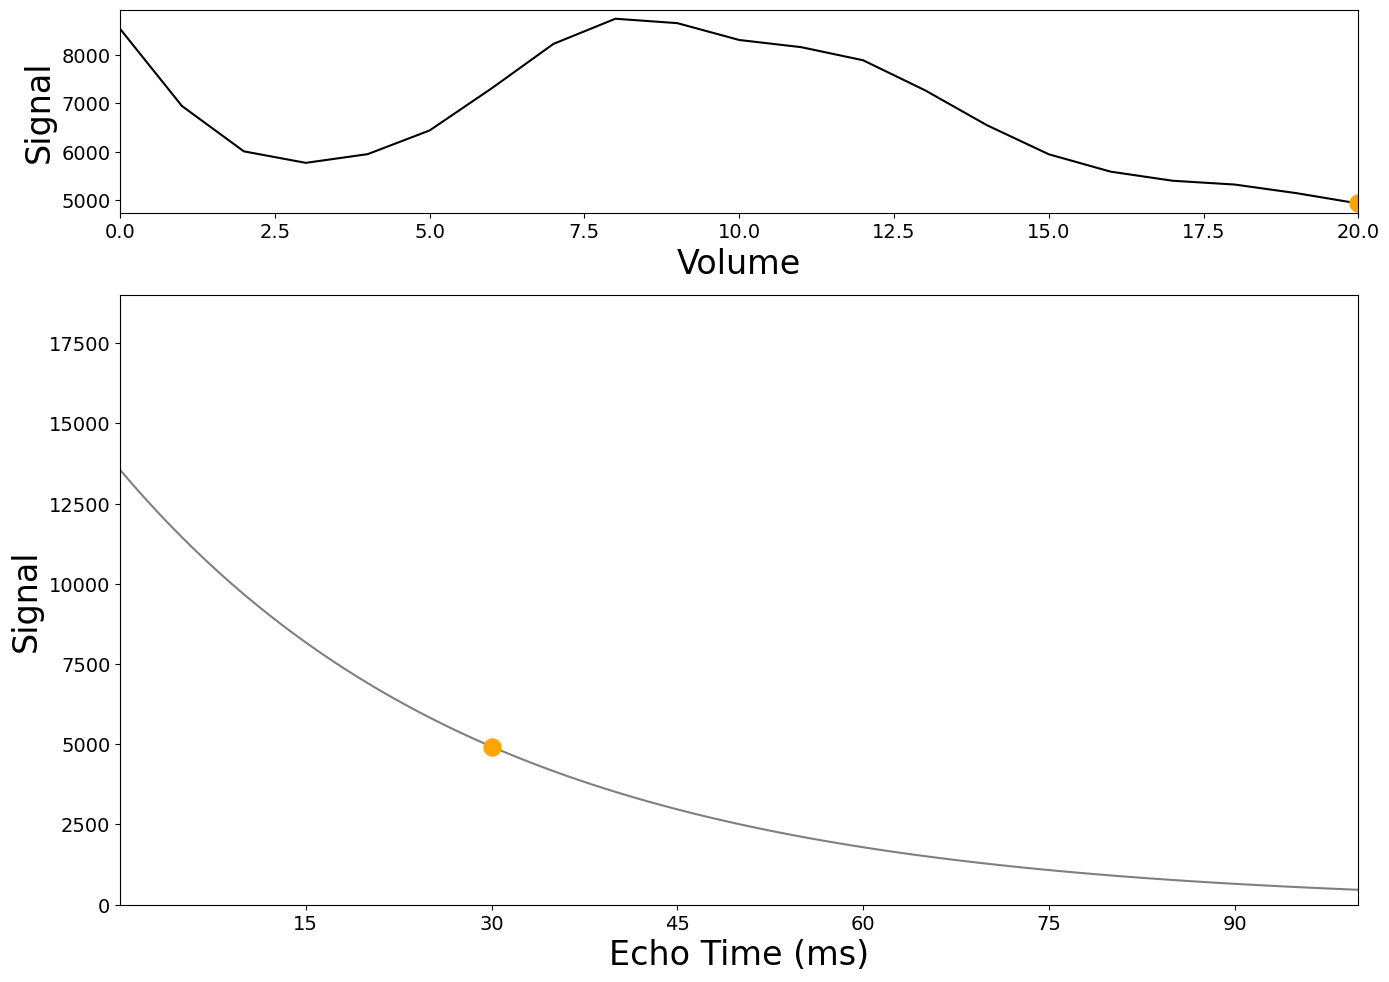

In [8]:
fullcurve_signal = predict_bold_signal(FULLCURVE_TES, s0_ts, t2s_ts)
singleecho_signal = fullcurve_signal[SINGLEECHO_TE, :]

# gif code based on https://www.geeksforgeeks.org/create-an-animated-gif-using-python-matplotlib/
fig, axes = plt.subplots(nrows=2, figsize=(14, 10), gridspec_kw={"height_ratios": [1, 3]})

# Set constant params for figure
axes[0].set_ylabel("Signal", fontsize=24)
axes[0].set_xlabel("Volume", fontsize=24)
axes[0].set_xlim(0, N_VOLS - 1)
axes[0].tick_params(axis="both", which="major", labelsize=14)
axes[1].set_ylabel("Signal", fontsize=24)
axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
axes[1].set_xticks(MULTIECHO_TES)
axes[1].set_ylim(0, np.ceil(np.max(fullcurve_signal) / 1000) * 1000)
axes[1].set_xlim(0, np.max(FULLCURVE_TES))
axes[1].tick_params(axis="both", which="major", labelsize=14)
fig.tight_layout()

ax0_line_plot = axes[0].plot(
    singleecho_signal[0, :],
    color="black",
    zorder=0
)
ax0_scatter_plot = axes[0].scatter(
    0,
    singleecho_signal[:, 0],
    color="orange",
    s=150,
    label="Single-Echo Signal",
    zorder=1,
)
ax1_line_plot = axes[1].plot(
    FULLCURVE_TES,
    fullcurve_signal[:, 0],
    alpha=0.5,
    color="black",
    zorder=0,
)[0]
ax1_scatter_plot = axes[1].scatter(
    SINGLEECHO_TE,
    singleecho_signal[:, 0],
    color="orange",
    s=150,
    alpha=1.,
    label="Single-Echo Signal",
    zorder=1,
)

def AnimationFunction(frame):
    """Function takes frame as an input."""
    ax0_scatter_plot.set_offsets(
        np.column_stack((
            frame,
            singleecho_signal[:, frame],
        ))
    )

    ax1_line_plot.set_data((
        FULLCURVE_TES,
        fullcurve_signal[:, frame],
    ))
    ax1_scatter_plot.set_offsets(
        np.column_stack((
            SINGLEECHO_TE,
            singleecho_signal[:, frame],
        ))
    )

anim_created = FuncAnimation(fig, AnimationFunction, frames=N_VOLS, interval=100)

html = display.HTML(anim_created.to_jshtml())
#display.display(html)

from myst_nb import glue
glue("fig_signal_decay", html, display=False)

```{glue:figure} fig_signal_decay
:name: fig_signal_decay
:align: center

Check it out.
```

### Plot single-echo data, the curve, and the $S_{0}$ and $T_{2}^{*}$ values resulting from $S_{0}$ and $T_{2}^{*}$ fluctuations

This shows how changes in fMRI data can be driven by both S0 and T2* fluctuations.

In [9]:
fullcurve_signal = predict_bold_signal(FULLCURVE_TES, s0_ts, t2s_ts)
singleecho_signal = fullcurve_signal[SINGLEECHO_TE, :]

out_file = os.path.join(out_dir, "fluctuations_single-echo_with_curve_and_t2s_s0.gif")
if os.path.isfile(out_file):
    os.remove(out_file)

filenames = []

for i_vol in range(N_VOLS):
    filename = f"se_{i_vol}.png"
    fig, axes = plt.subplots(
        nrows=2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [1, 3]}
    )

    axes[0].plot(
        singleecho_signal[0, :],
        color="black",
        zorder=0,
    )
    axes[0].scatter(
        i_vol,
        singleecho_signal[:, i_vol],
        color="orange",
        s=150,
        label="Single-Echo Signal",
        zorder=1,
    )
    axes[0].set_ylabel("Signal", fontsize=24)
    axes[0].set_xlabel("Volume", fontsize=24)
    axes[0].set_xlim(0, N_VOLS - 1)
    axes[0].tick_params(axis="both", which="major", labelsize=14)

    axes[1].scatter(
        SINGLEECHO_TE,
        singleecho_signal[:, i_vol],
        color="orange",
        s=150,
        alpha=1.,
        label="Single-Echo Signal",
        zorder=3,
    )

    axes[1].plot(
        FULLCURVE_TES,
        fullcurve_signal[:, i_vol],
        alpha=0.5,
        color="black",
        zorder=0,
    )

    t2s_value = predict_bold_signal(
        np.array([t2s_ts[i_vol]]),
        np.array([s0_ts[i_vol]]),
        np.array([t2s_ts[i_vol]])
    )[0]
    axes[1].scatter(
        t2s_ts[i_vol],
        t2s_value,
        marker="*",
        color="blue",
        s=500,
        alpha=0.5,
        label="$T_{2}^{*}$",
        zorder=1,
    )
    axes[1].scatter(
        0,
        s0_ts[i_vol],
        marker="*",
        color="red",
        s=500,
        alpha=0.5,
        label="$S_{0}$",
        clip_on=False,
        zorder=2,
    )

    axes[1].legend(loc="upper right", fontsize=20)

    axes[1].set_ylabel("Signal", fontsize=24)
    axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
    axes[1].set_xticks(MULTIECHO_TES)
    axes[1].set_ylim(0, np.ceil(np.max(fullcurve_signal) / 1000) * 1000)
    axes[1].set_xlim(0, np.max(FULLCURVE_TES))
    axes[1].tick_params(axis="both", which="major", labelsize=14)
    fig.tight_layout()

    # save frame
    fig.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# build gif
with imageio.get_writer(out_file, mode="I") as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove temporary files
for filename in filenames:
    os.remove(filename)

with open(out_file, "rb") as file:
    display(display.Image(file.read(), width=600))

TypeError: 'module' object is not callable

### Plot $S_{0}$ and $T_{2}^{*}$ fluctuations

This shows how fluctuations in S0 and T2* produce different patterns in the full signal decay curves.

In [ ]:
s0based_fullcurve_signal = predict_bold_signal(FULLCURVE_TES, s0_ts, np.full(N_VOLS, MEAN_T2S))
t2sbased_fullcurve_signal = predict_bold_signal(FULLCURVE_TES, np.full(N_VOLS, MEAN_S0), t2s_ts)

out_file = os.path.join(out_dir, "fluctuations_t2s_s0.gif")
if os.path.isfile(out_file):
    os.remove(out_file)

filenames = []

for i_vol in range(N_VOLS):
    filename = f"total_{i_vol}.png"
    fig, axes = plt.subplots(
        nrows=2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [1, 3]}
    )

    axes[0].plot(ts, color="black")
    axes[0].scatter(
        i_vol,
        ts[i_vol],
        color="purple",
        s=150,
    )
    axes[0].set_ylabel("$S_0$/$T_{2}^{*}$", fontsize=24)
    axes[0].set_xlabel("Volume", fontsize=24)
    axes[0].set_xlim(0, N_VOLS - 1)
    axes[0].tick_params(axis="both", which="major", labelsize=14)

    axes[1].plot(
        FULLCURVE_TES,
        s0based_fullcurve_signal[:, i_vol],
        color="red",
        alpha=0.5,
        label="$S_0$-Driven Decay Curve",
    )
    axes[1].plot(
        FULLCURVE_TES,
        t2sbased_fullcurve_signal[:, i_vol],
        color="blue",
        alpha=0.5,
        label="$T_{2}^{*}$-Driven Decay Curve",
    )
    axes[1].legend(loc="upper right", fontsize=20)

    axes[1].set_ylabel("Signal", fontsize=24)
    axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
    axes[1].set_xticks(MULTIECHO_TES)
    axes[1].set_ylim(0, np.ceil(np.max(s0based_fullcurve_signal) / 1000) * 1000)
    axes[1].set_xlim(0, np.max(FULLCURVE_TES))
    axes[1].tick_params(axis="both", which="major", labelsize=14)
    fig.tight_layout()

    # save frame
    fig.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# build gif
with imageio.get_writer(out_file, mode="I") as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove temporary files
for filename in filenames:
    os.remove(filename)

with open(out_file, "rb") as file:
    display(display.Image(file.read(), width=600))

### Plot $S_{0}$ and $T_{2}^{*}$ fluctuations and resulting single-echo data

This shows how single-echo data, on its own, cannot distinguish between S0 and T2* fluctuations.

In [ ]:
s0based_fullcurve_signal = predict_bold_signal(FULLCURVE_TES, s0_ts, np.full(N_VOLS, MEAN_T2S))
t2sbased_fullcurve_signal = predict_bold_signal(FULLCURVE_TES, np.full(N_VOLS, MEAN_S0), t2s_ts)
s0based_singleecho_signal = s0based_fullcurve_signal[SINGLEECHO_TE, :]
t2sbased_singleecho_signal = t2sbased_fullcurve_signal[SINGLEECHO_TE, :]

out_file = os.path.join(out_dir, "fluctuations_t2s_s0_single-echo.gif")
if os.path.isfile(out_file):
    os.remove(out_file)

filenames = []

for i_vol in range(N_VOLS):
    filename = f"total_{i_vol}.png"
    fig, axes = plt.subplots(
        nrows=2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [1, 3]}
    )

    axes[0].plot(
        ts,
        color="black",
        zorder=0,
    )
    axes[0].scatter(
        i_vol,
        ts[i_vol],
        color="purple",
        s=150,
        zorder=1,
    )
    axes[0].set_ylabel("$S_0$/$T_{2}^{*}$", fontsize=24)
    axes[0].set_xlabel("Volume", fontsize=24)
    axes[0].set_xlim(0, N_VOLS - 1)
    axes[0].tick_params(axis="both", which="major", labelsize=14)

    axes[1].plot(
        FULLCURVE_TES,
        s0based_fullcurve_signal[:, i_vol],
        color="red",
        alpha=0.5,
        label="$S_0$-Driven Decay Curve",
        zorder=0,
    )
    axes[1].plot(
        FULLCURVE_TES,
        t2sbased_fullcurve_signal[:, i_vol],
        color="blue",
        alpha=0.5,
        label="$T_{2}^{*}$-Driven Decay Curve",
        zorder=1,
    )
    axes[1].scatter(
        SINGLEECHO_TE,
        s0based_singleecho_signal[:, i_vol],
        color="red",
        s=150,
        alpha=1.,
        label="$S_0$-Driven Single-Echo Signal",
        zorder=2,
    )
    axes[1].scatter(
        SINGLEECHO_TE,
        t2sbased_singleecho_signal[:, i_vol],
        color="blue",
        s=150,
        alpha=1.,
        label="$T_{2}^{*}$-Driven Single-Echo Signal",
        zorder=3,
    )
    axes[1].legend(loc="upper right", fontsize=20)

    axes[1].set_ylabel("Signal", fontsize=24)
    axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
    axes[1].set_xticks(MULTIECHO_TES)
    axes[1].set_ylim(0, np.ceil(np.max(s0based_fullcurve_signal) / 1000) * 1000)
    axes[1].set_xlim(0, np.max(FULLCURVE_TES))
    axes[1].tick_params(axis="both", which="major", labelsize=14)
    fig.tight_layout()

    # save frame
    fig.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# build gif
with imageio.get_writer(out_file, mode="I") as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove temporary files
for filename in filenames:
    os.remove(filename)

with open(out_file, "rb") as file:
    display(display.Image(file.read(), width=600))

### Plot $S_{0}$ and $T_{2}^{*}$ fluctuations and resulting multi-echo data

This shows how S0 and T2* fluctuations produce different patterns in multi-echo data.

In [ ]:
s0based_fullcurve_signal = predict_bold_signal(FULLCURVE_TES, s0_ts, np.full(N_VOLS, MEAN_T2S))
t2sbased_fullcurve_signal = predict_bold_signal(FULLCURVE_TES, np.full(N_VOLS, MEAN_S0), t2s_ts)
s0based_multiecho_signal = s0based_fullcurve_signal[MULTIECHO_TES, :]
t2sbased_multiecho_signal = t2sbased_fullcurve_signal[MULTIECHO_TES, :]

out_file = os.path.join(out_dir, "fluctuations_t2s_s0_multi-echo.gif")
if os.path.isfile(out_file):
    os.remove(out_file)

filenames = []

for i_vol in range(N_VOLS):
    filename = f"total_{i_vol}.png"
    fig, axes = plt.subplots(
        nrows=2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [1, 3]}
    )

    axes[0].plot(
        ts,
        color="black",
        zorder=0,
    )
    axes[0].scatter(
        i_vol,
        ts[i_vol],
        color="purple",
        s=150,
        zorder=1,
    )
    axes[0].set_ylabel("$S_0$/$T_{2}^{*}$", fontsize=24)
    axes[0].set_xlabel("Volume", fontsize=24)
    axes[0].set_xlim(0, N_VOLS - 1)
    axes[0].tick_params(axis="both", which="major", labelsize=14)

    axes[1].plot(
        FULLCURVE_TES,
        s0based_fullcurve_signal[:, i_vol],
        color="red",
        alpha=0.5,
        label="$S_0$-Driven Decay Curve",
        zorder=0,
    )
    axes[1].plot(
        FULLCURVE_TES,
        t2sbased_fullcurve_signal[:, i_vol],
        color="blue",
        alpha=0.5,
        label="$T_{2}^{*}$-Driven Decay Curve",
        zorder=1,
    )
    axes[1].scatter(
        MULTIECHO_TES,
        s0based_multiecho_signal[:, i_vol],
        color="red",
        s=150,
        alpha=1.,
        label="$S_0$-Driven Multi-Echo Signal",
        zorder=2,
    )
    axes[1].scatter(
        MULTIECHO_TES,
        t2sbased_multiecho_signal[:, i_vol],
        color="blue",
        s=150,
        alpha=1.,
        label="$T_{2}^{*}$-Driven Multi-Echo Signal",
        zorder=3,
    )
    axes[1].legend(loc="upper right", fontsize=20)

    axes[1].set_ylabel("Signal", fontsize=24)
    axes[1].set_xlabel("Echo Time (ms)", fontsize=24)
    axes[1].set_xticks(MULTIECHO_TES)
    axes[1].set_ylim(0, np.ceil(np.max(s0based_fullcurve_signal) / 1000) * 1000)
    axes[1].set_xlim(0, np.max(FULLCURVE_TES))
    axes[1].tick_params(axis="both", which="major", labelsize=14)
    fig.tight_layout()

    # save frame
    fig.savefig(filename)
    plt.close(fig)
    filenames.append(filename)

# build gif
with imageio.get_writer(out_file, mode="I") as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove temporary files
for filename in filenames:
    os.remove(filename)

with open(out_file, "rb") as file:
    display(display.Image(file.read(), width=600))

#### Plot $T_{2}^{*}$ against BOLD signal from single-echo data (TE=30ms)

When the BOLD signal is driven entirely by T2* fluctuations,
the BOLD signal is very similar to a scaled version of those T2* fluctuations, but there are small differences.

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))

scalar = np.linalg.lstsq(
    t2s_ts[:, None],
    t2sbased_fullcurve_signal[SINGLEECHO_TE[0], :],
    rcond=None
)[0]
ax.plot(
    t2sbased_fullcurve_signal[SINGLEECHO_TE[0], :],
    color="orange",
    label=f"BOLD signal (TE={SINGLEECHO_TE[0]}ms)",
)
ax.plot(
    t2s_ts * scalar,
    label="$T_{2}^{*}$ (scaled to signal)",
    linestyle="--",
)
ax.set_xlim(0, N_VOLS - 1)
leg = ax.legend()
fig.show()

#### Plot $S_{0}$ against BOLD signal from single-echo data (TE=30ms)

When the BOLD signal is driven entirely by S0 fluctuations, the BOLD signal ends up being a scaled version of the S0 fluctuations.

In [ ]:
fig, ax = plt.subplots(figsize=(16, 4))

scalar = np.linalg.lstsq(
    s0_ts[:, None],
    s0based_fullcurve_signal[SINGLEECHO_TE[0], :],
    rcond=None
)[0]
ax.plot(
    s0based_fullcurve_signal[SINGLEECHO_TE[0], :],
    color="orange",
    label=f"BOLD signal (TE={SINGLEECHO_TE[0]}ms)",
)
ax.plot(
    s0_ts * scalar,
    label="S0 (scaled to signal)",
    linestyle="--",
)
ax.set_xlim(0, N_VOLS - 1)
leg = ax.legend()
fig.show()